In [1]:
import sys
from scipy.stats import loguniform

sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime
from joblib import dump
from shutil import rmtree
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from tempfile import mkdtemp

from src.helpers import PorterTokenizer

[nltk_data] Downloading package punkt to /home/nixwill/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nixwill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
with open('../data/cleaned/encoder.pickle', 'rb') as i:
    encoder = pickle.load(i)

In [4]:
train_df = pd.read_csv('../data/cleaned/train.csv')
test_df = pd.read_csv('../data/cleaned/test.csv')
train_df

,country,description,points,price,taster_name,points_group
0,Argentina,"Slightly gritty, nutty aromas indicate that th...",84,18.0,Michael Schachner,1
1,Portugal,Merlot and Syrah are added to Portuguese varie...,87,12.0,Roger Voss,2
2,France,Ripe mirabelle fruit plays on the nose and lea...,92,35.0,Anne Krebiehl MW,3
3,Italy,"This blend of 70% Sangiovese with Canaiolo, Co...",88,14.0,Kerin O’Keefe,2
4,Italy,"It opens with aromas of forest floor, porcini ...",88,28.0,Kerin O’Keefe,2
...,...,...,...,...,...,...
69907,France,"Light and only gently structured, this is a cr...",87,18.0,Roger Voss,2
69908,Germany,Veins of smoke and wax seep through fresh appl...,87,18.0,Anna Lee C. Iijima,2
69909,US,A combination of American and Hungarian oak le...,88,16.0,Anna Lee C. Iijima,2
69910,France,"Based in the heart of the Haut-Médoc, this pro...",84,20.0,Roger Voss,1


In [5]:
X_train_df = train_df[['price', 'country', 'taster_name', 'description']]
y_train_clf = train_df['points_group']
y_train_reg = train_df['points']

X_test_df = test_df[['price', 'country', 'taster_name', 'description']]
y_test_clf = test_df['points_group']
y_test_reg = test_df['points']

In [6]:
def make_custom_transformer():
    return make_column_transformer(
        (make_pipeline(
            PolynomialFeatures(2, include_bias=False),
            MinMaxScaler(feature_range=(0, 1)),
        ), ['price']),
        (OneHotEncoder(handle_unknown='ignore'), ['country', 'taster_name']),
        (TfidfVectorizer(
            tokenizer=PorterTokenizer(),
            max_df=0.7,
            min_df=7,
            ngram_range=(1, 1),
        ), 'description'),
    )

In [7]:
cachedir = mkdtemp()

## Baseline

In [8]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_df, y_train_clf)
y_pred = dummy_clf.predict(X_test_df)
print(classification_report(y_test_clf, y_pred, target_names=encoder.classes_))

                                                                          precision    recall  f1-score   support

80-82 Acceptable Can be employed in casual, less-critical circumstances.       0.01      0.01      0.01       337
         83-86 Good Suitable for everyday consumption; often good value.       0.24      0.24      0.24      4021
                     87-89 Very Good Often good value; well recommended.       0.37      0.37      0.37      6367
                                     90-93 Excellent Highly recommended.       0.35      0.35      0.35      6061
                                       94-97 Superb A great achievement.       0.06      0.05      0.05       847
                                 98-100 Classic The pinnacle of quality.       0.00      0.00      0.00        20

                                                                accuracy                           0.31     17653
                                                               macro avg       0.17   

/home/nixwill/workspace/oznal/venv/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


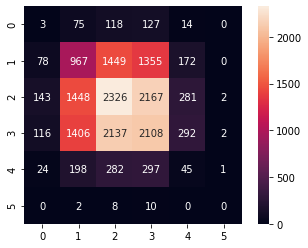

In [9]:
conf_matrix = confusion_matrix(y_test_clf, y_pred, labels=range(len(encoder.classes_)))
sns.heatmap(conf_matrix, annot=True, fmt='d', square=True)

## Complement Naive Bayes

In [10]:
pipe = Pipeline(
    [
        ('transformer', make_custom_transformer()),
        ('estimator', ComplementNB()),
    ],
    memory=cachedir,
)

param_grid = dict(
    transformer__tfidfvectorizer__max_df=[0.7, 1.0],
    transformer__tfidfvectorizer__min_df=[7, 0.01, 1.0],
    transformer__tfidfvectorizer__ngram_range=[(1, 1), (1, 2)],
    estimator__alpha=[0.0, 0.5, 1.0],
    estimator__norm=[True, False]
)

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=4,
    n_jobs=-1,
    verbose=3,
    scoring=['f1_weighted', 'balanced_accuracy'],
    refit='f1_weighted',
)

grid_search = grid_search.fit(X_train_df, y_train_clf)
dump(grid_search, f'../models/CNB-{datetime.now().isoformat()}.joblib')

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 60.3min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 62.0min finished
/home/nixwill/workspace/oznal/venv/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 5.04s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


['../models/CNB-2020-05-16T04:15:00.886352.joblib']

In [11]:
grid_search.best_params_

{'estimator__alpha': 0.5,
 'estimator__norm': True,
 'transformer__tfidfvectorizer__max_df': 0.7,
 'transformer__tfidfvectorizer__min_df': 7,
 'transformer__tfidfvectorizer__ngram_range': (1, 2)}

In [12]:
y_pred = grid_search.predict(X_test_df)
print(classification_report(y_test_clf, y_pred, target_names=encoder.classes_))

                                                                          precision    recall  f1-score   support

80-82 Acceptable Can be employed in casual, less-critical circumstances.       0.00      0.00      0.00       337
         83-86 Good Suitable for everyday consumption; often good value.       0.50      0.65      0.57      4021
                     87-89 Very Good Often good value; well recommended.       0.57      0.41      0.48      6367
                                     90-93 Excellent Highly recommended.       0.59      0.75      0.66      6061
                                       94-97 Superb A great achievement.       0.75      0.01      0.02       847
                                 98-100 Classic The pinnacle of quality.       0.00      0.00      0.00        20

                                                                accuracy                           0.56     17653
                                                               macro avg       0.40   

/home/nixwill/workspace/oznal/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


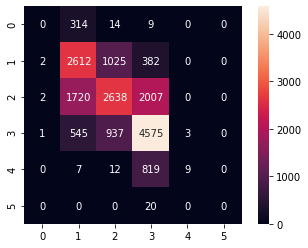

In [13]:
conf_matrix = confusion_matrix(y_test_clf, y_pred, labels=range(len(encoder.classes_)))
sns.heatmap(conf_matrix, annot=True, fmt='d', square=True)

## Stochastic Gradient Descent

In [14]:
pipe = Pipeline(
    [
        ('transformer', make_custom_transformer()),
        ('estimator', SGDClassifier(random_state=42)),
    ],
    memory=cachedir,
)

param_grid = dict(
    transformer__tfidfvectorizer__max_df=[0.7],
    transformer__tfidfvectorizer__min_df=[7, 0.01],
    # transformer__tfidfvectorizer__ngram_range=[(1, 1), (1, 2)],
    estimator__loss=['log', 'modified_huber'],
    estimator__penalty=['l2', 'l1', 'elasticnet'],
    estimator__alpha=[0.0001, 0.001, 0.05],
    estimator__class_weight=['balanced', None],
    estimator__average=[True, False],
)

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=4,
    n_jobs=-1,
    verbose=3,
    scoring=['f1_weighted', 'balanced_accuracy'],
    refit='f1_weighted',
)

grid_search = grid_search.fit(X_train_df, y_train_clf)
dump(grid_search, f'../models/SGDC-{datetime.now().isoformat()}.joblib')

Fitting 4 folds for each of 144 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 52.2min finished
/home/nixwill/workspace/oznal/venv/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


['../models/SGDC-2020-05-16T05:07:56.905167.joblib']

In [15]:
grid_search.best_params_

{'estimator__alpha': 0.0001,
 'estimator__average': True,
 'estimator__class_weight': None,
 'estimator__loss': 'modified_huber',
 'estimator__penalty': 'l2',
 'transformer__tfidfvectorizer__max_df': 0.7,
 'transformer__tfidfvectorizer__min_df': 7}

In [16]:
y_pred = grid_search.predict(X_test_df)
print(classification_report(y_test_clf, y_pred, target_names=encoder.classes_))

                                                                          precision    recall  f1-score   support

80-82 Acceptable Can be employed in casual, less-critical circumstances.       0.84      0.09      0.17       337
         83-86 Good Suitable for everyday consumption; often good value.       0.65      0.66      0.65      4021
                     87-89 Very Good Often good value; well recommended.       0.63      0.61      0.62      6367
                                     90-93 Excellent Highly recommended.       0.67      0.81      0.73      6061
                                       94-97 Superb A great achievement.       0.67      0.12      0.21       847
                                 98-100 Classic The pinnacle of quality.       0.00      0.00      0.00        20

                                                                accuracy                           0.65     17653
                                                               macro avg       0.58   

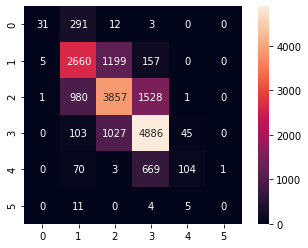

In [17]:
conf_matrix = confusion_matrix(y_test_clf, y_pred, labels=range(len(encoder.classes_)))
sns.heatmap(conf_matrix, annot=True, fmt='d', square=True)

## Random Forest

In [24]:
pipe = Pipeline(
    [
        ('transformer', make_custom_transformer()),
        ('estimator', RandomForestClassifier(random_state=42)),
    ],
    memory=cachedir,
)

param_grid = dict(
    estimator__n_estimators=[50, 100, 250, 500, 1000],
    estimator__max_features=['sqrt', 'log2'],
    estimator__max_depth=[100]
)

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=2,
    n_jobs=-1,
    verbose=3,
    scoring=['f1_weighted', 'balanced_accuracy'],
    refit='f1_weighted',
)

grid_search = grid_search.fit(X_train_df, y_train_clf)
dump(grid_search, f'../models/RF-{datetime.now().isoformat()}.joblib')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 24.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 24.8min finished


['../models/RF-2020-05-16T12:07:48.580678.joblib']

In [25]:
grid_search.best_params_

{'estimator__max_depth': 100,
 'estimator__max_features': 'sqrt',
 'estimator__n_estimators': 1000}

In [26]:
y_pred = grid_search.predict(X_test_df)
print(classification_report(y_test_clf, y_pred, target_names=encoder.classes_))

                                                                          precision    recall  f1-score   support

80-82 Acceptable Can be employed in casual, less-critical circumstances.       0.00      0.00      0.00       337
         83-86 Good Suitable for everyday consumption; often good value.       0.70      0.57      0.63      4021
                     87-89 Very Good Often good value; well recommended.       0.60      0.68      0.64      6367
                                     90-93 Excellent Highly recommended.       0.67      0.79      0.72      6061
                                       94-97 Superb A great achievement.       0.94      0.02      0.03       847
                                 98-100 Classic The pinnacle of quality.       0.00      0.00      0.00        20

                                                                accuracy                           0.65     17653
                                                               macro avg       0.48   

/home/nixwill/workspace/oznal/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


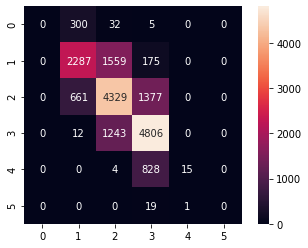

In [27]:
conf_matrix = confusion_matrix(y_test_clf, y_pred, labels=range(len(encoder.classes_)))
sns.heatmap(conf_matrix, annot=True, fmt='d', square=True)

In [28]:
rmtree(cachedir)
